In [2]:
import numpy as np
import scipy as sp
import pandas as pd
import pymc as pm
import arviz as az
from matplotlib import pyplot as plt
import seaborn as sns
from math import factorial as f

# Binomial distribution
def dbinom(x,n,p):
    return f(n)/(f(x)*f(n-x))*p**(x)*(1-p)**(n-x)

### Our first model. Estimating the presence/absence of frogs at a pond.

**Scenario**: We go to a pond 30 times and record the presence (1) or absence (0) of frogs, and try and estimate the probability of seeing a frog when visiting the pond.

### Generative model and simulated data.

In [3]:
# number of trips to pond
n_trips = 30

# the true probability of seeing a frog in this pond
true_prob = 0.35

# simulate data with our generative model
sim_data = np.random.binomial(n=1, size=n_trips, p=true_prob)

# number of times seen a frog
n_frogs = sum(sim_data)

sim_data

array([0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 1, 0, 1, 0, 1, 1])

### Build statistical model: grid approximation
**Model Components**
1. **Grid**, a finite set of parameters values to be used
2. **Prior Distribution**, prior probability for each value of the parameter
3. **Data Likelihood**, the distribution function assigned to our observed variables. This function gives us the likelihood of the data for every plausible value of our parameter.
4. **Posterior Distribution**, contains the probability of different parameter values, conditional on the data and model.

#### Bayesian Notation

$$F \sim Binomial(n, p)$$
$$p \sim Uniform(0,1)$$

In [6]:
# grid approximation
par_grid = np.linspace(start=0, stop=1, num=20) # 20 candidate values of p

# uniform prior
prior = np.repeat(1, 20)
prior = prior/sum(prior)

# likelihood
likelihood = dbinom(n_frogs, n_trips, par_grid)

# posterior
posterior = likelihood*prior/sum(likelihood*prior)

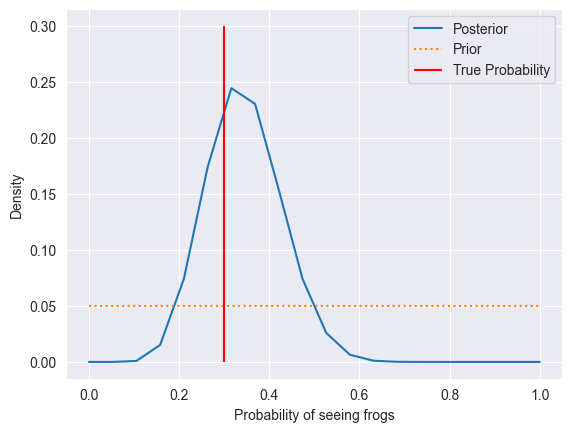

In [7]:
plt.plot(par_grid, posterior)
plt.plot(par_grid, prior,linestyle=":")
plt.vlines(0.3, ymin=0, ymax=0.3, colors="red")
plt.xlabel('Probability of seeing frogs')
plt.ylabel('Density')
plt.legend(['Posterior', 'Prior', 'True Probability']);

In [8]:
# summarise our posterior - grid approximation
samples = np.random.choice(par_grid, p=posterior, size=1000, replace=True)
# mean
samples.mean()

np.float64(0.34742105263157896)

In [9]:
# how much of the posterior is above/below a value?
posterior[ par_grid < 0.4 ].sum(), posterior[ par_grid > 0.4 ].sum()

(np.float64(0.7388031786754474), np.float64(0.26119682132455246))

In [10]:
# compatibility intervals
# highest posterior density interval (HPDI) - best representatives of parameter values
az.hdi(samples, hdi_prob=0.5)

array([0.26315789, 0.36842105])

### Build statistical model: MCMC
- **Model data,** a list containing our variables and data
- **Prior Distribution**, prior probability of the parameter at each probability
- **Data Likelihood**, the distribution function assigned to our observed variables. This function gives us the likelihood of the data for every plausible value of our parameter.

In [11]:
with pm.Model() as frog_model:
    p = pm.Uniform('p', 0, 1) # uniform prior
    frogs = pm.Binomial('frogs', n=n_trips, p=p, observed=n_frogs ) # data likelihood
    
    idata = pm.sample() # sample from posterior

az.summary(idata)


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


/Users/aoakley/Library/Mobile 
Documents/com~apple~CloudDocs/Active_Projects/Dalhousie/AppliedBayes_2025/.venv/lib/python3.12/site-packages/rich/l
ive.py:256: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p,0.344,0.08,0.204,0.499,0.002,0.001,1755.0,2770.0,1.0


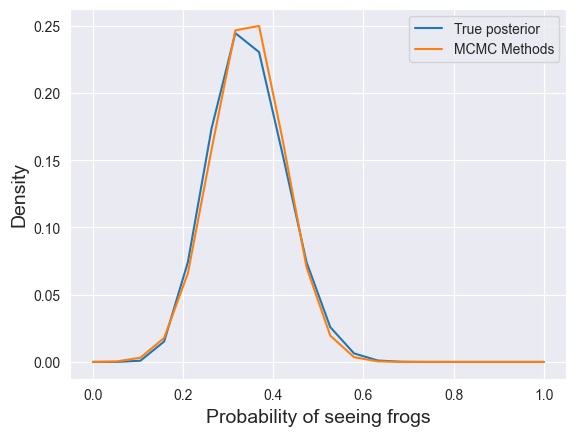

In [12]:
# analytical calculation
y1 = dbinom(n_frogs,n_trips,par_grid)
plt.plot(par_grid, y1/sum(y1), label='True posterior')

y2 = sp.stats.norm.pdf(par_grid, idata['posterior']['p'].mean(), idata['posterior']['p'].std())
plt.plot(par_grid, y2/sum(y2), label='MCMC Methods')
plt.legend()

plt.xlabel('Probability of seeing frogs', fontsize=14)
plt.ylabel('Density', fontsize=14);

In [72]:
frog_model

    p ~ Uniform(0, 1)
frogs ~ Binomial(30, p)

### Using an Informed Prior

In the last model, we assumed ignorance about the probability of seeing frogs at the pond, by using an uninformed uniform prior.

What if we had some prior knowledge about this pond? For example, we know that this pond is in an area where frogs are very common, and we expect to see them most of the time.

We can use a Beta distribution to represent this prior knowledge. Why a Beta distribution? Because it is defined on the interval [0, 1], which is suitable for probabilities, and it can take on a variety of shapes depending on its parameters.

But what parameters should we use for the Beta distribution? Let's say we expect to see frogs 40% of the time, and we are quite confident about this. We can use the parameters alpha = 5 and beta = 8, which gives us a prior mean of about 0.4 and a relatively narrow distribution.

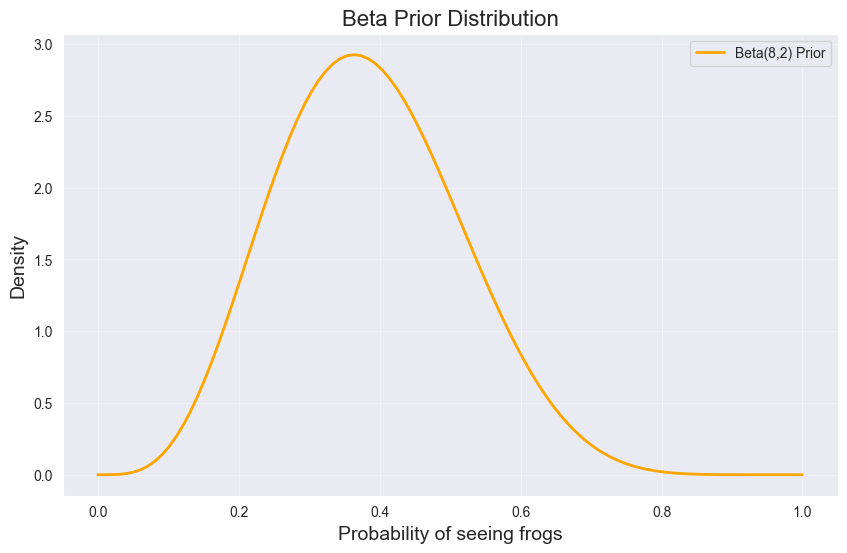

Prior mean: 0.38461538461538464
Prior mode: 0.36363636363636365


In [17]:
# visualize the beta prior
x = np.linspace(0, 1, 100)
beta_prior = sp.stats.beta.pdf(x, a=5, b=8)

plt.figure(figsize=(10, 6))
plt.plot(x, beta_prior, 'orange', linewidth=2, label='Beta(8,2) Prior')
plt.xlabel('Probability of seeing frogs', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.title('Beta Prior Distribution', fontsize=16)
plt.legend()
plt.grid(True, alpha=0.35)
plt.show()

print(f"Prior mean: {5/(5+8)}")
print(f"Prior mode: {(5-1)/((5-1)+(8-1))}")  # mode for beta distribution

Now let's fit the model again using this informed Beta prior.

In [14]:
# MCMC method using PyMC with informed Beta prior
with pm.Model() as frog_model_beta:
    p = pm.Beta('p', alpha=5, beta=8)  # informed beta prior
    frogs = pm.Binomial('frogs', n=n_trips, p=p, observed=n_frogs)  # data likelihood
    
    idata_beta = pm.sample()  # sample from posterior

az.summary(idata_beta)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p,0.45,0.078,0.313,0.603,0.002,0.001,1677.0,2546.0,1.0


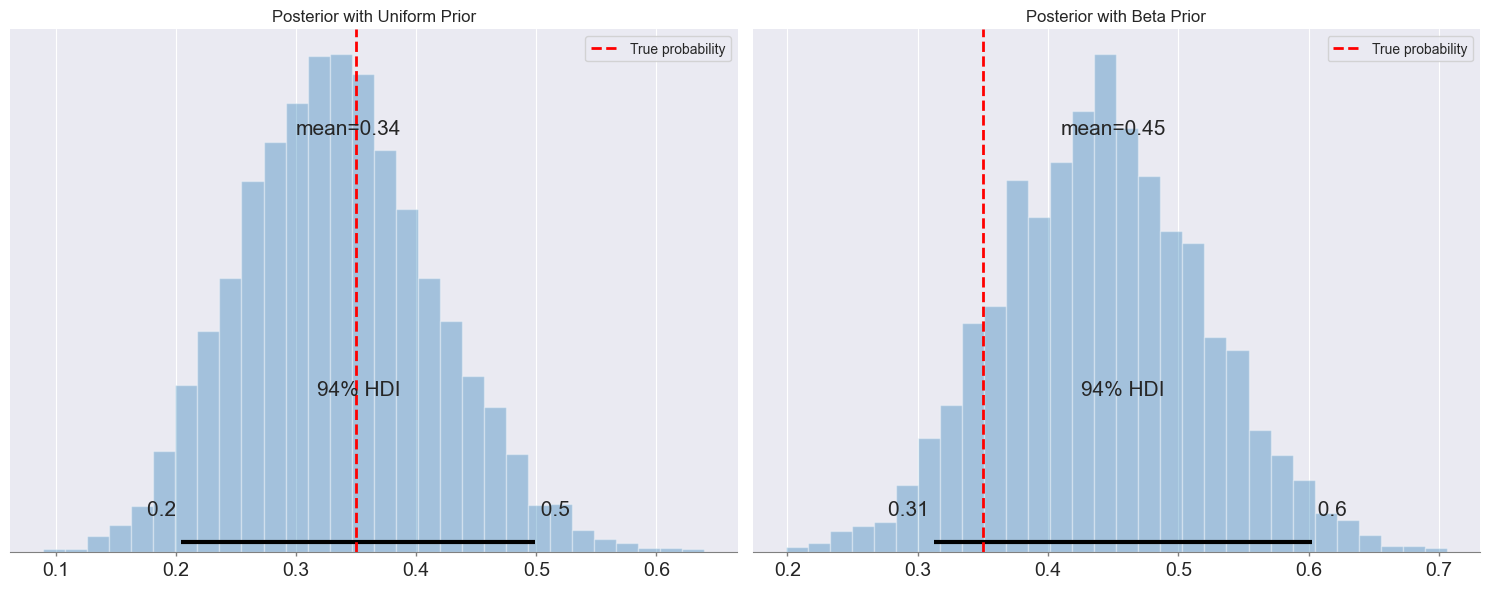

    mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
p  0.344  0.08   0.204    0.499      0.002    0.001    1755.0    2770.0    1.0
   mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
p  0.45  0.078   0.313    0.603      0.002    0.001    1677.0    2546.0    1.0


In [16]:
# compare posteriors from uniform and beta priors
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# uniform prior results
ax1 = axes[0]
az.plot_posterior(idata, var_names=['p'], ax=ax1, kind='hist', bins=30)
ax1.axvline(true_prob, color='red', linestyle='--', linewidth=2, label='True probability')
ax1.set_title('Posterior with Uniform Prior')
ax1.legend()

# beta prior results  
ax2 = axes[1]
az.plot_posterior(idata_beta, var_names=['p'], ax=ax2, kind='hist', bins=30)
ax2.axvline(true_prob, color='red', linestyle='--', linewidth=2, label='True probability')
ax2.set_title('Posterior with Beta Prior')
ax2.legend()

plt.tight_layout()
plt.show()

# compare summaries
print(az.summary(idata))
print(az.summary(idata_beta))

In [ ]:
# posterior summaries for beta prior model
samples_beta = idata_beta['posterior']['p'].values.flatten()

print("Beta Prior Model Results:")
print(f"Posterior mean: {samples_beta.mean():.3f}")
print(f"Posterior std: {samples_beta.std():.3f}")

# probability above 30%
prob_above_30 = (samples_beta > 0.3).mean()
print(f"Probability p > 0.3: {prob_above_30:.3f}")

# compatibility intervals using arviz
hdi_50 = az.hdi(idata_beta, var_names=['p'], hdi_prob=0.5)
hdi_96 = az.hdi(idata_beta, var_names=['p'], hdi_prob=0.96)

print(f"50% HDI: [{hdi_50['p'][0]:.3f}, {hdi_50['p'][1]:.3f}]")
print(f"89% HDI: [{hdi_96['p'][0]:.3f}, {hdi_96['p'][1]:.3f}]")